# FEniCSx tutorials

In this notebook, I learn the basics of FEniCSx by practicing with the tutorials. 

https://jsdokken.com/dolfinx-tutorial/chapter1/fundamentals.html

## 1 Solving the Poisson equation

$$
-\nabla^2 u(\mathbf{x}) = f(\mathbf{x}) \;\;\;\; \mathrm{x}\in \Omega
$$
$$
u(\mathbf{x}) = u_D(\mathbf{x})    \;\;\;\; \mathrm{x}\in \partial\Omega
$$

Here, the unknown function is $u$, governed by a diffusive laplacian term and a source term $f$. The second equation is the boundary condition. 

First, we need to reformulate the PDE as a finite element variational problem. Basic recipe is:

- Multiply the PDE by a function $v$
- Integrate the resulting equation over the domain $\Omega$
- Perform integration by parts of those terms with second order derivatives

Time both sides of the equation by a test function $v$, and integrate both sides over the domain

$$
\int_\Omega -\nabla^2 u \cdot v \,\mathrm{d}\Omega = \int_\Omega f v\,\mathrm{d}\Omega
$$

Integrate the left side by parts

$$
\int_\Omega -\nabla^2 u \cdot v \,\mathrm{d}\Omega = \int_\Omega -\nabla\cdot (\nabla u \cdot v) \,\mathrm{d}\Omega + \int_\Omega \nabla u \cdot\nabla v \,\mathrm{d}\Omega
$$

Use divergence theorem

$$
\int_\Omega -\nabla^2 u \cdot v \,\mathrm{d}\Omega = \int_{\partial\Omega} -\vec{n}\cdot (\nabla u \cdot v) \,\mathrm{d}s + \int_\Omega \nabla u \cdot\nabla v \,\mathrm{d}\Omega
$$

We define the test function $v$ as such, that the boundary term vanishes, the weak form of the PDE is arrived

$$
\int_\Omega -\nabla^2 u \cdot v \,\mathrm{d}\Omega = \int_\Omega \nabla u \cdot\nabla v \,\mathrm{d}\Omega = \int_\Omega f v\,\mathrm{d}\Omega
$$

The boundary condition is encoded in the test function $v$.

The problem can be further abstracted as

$$
a(u, v) = L(v)
$$

where

$$
a(u, v) = \int_\Omega \nabla u \cdot\nabla v \,\mathrm{d}\Omega
$$
$$
L(v) = \int_\Omega f v\,\mathrm{d}\Omega
$$

In [2]:
from mpi4py import MPI
from dolfinx import mesh
domain = mesh.create_unit_square(MPI.COMM_WORLD, 8, 8, mesh.CellType.quadrilateral)

We start with a know solution

$$
u(x, y) = 1 + x^2 + 2y^2
$$

on a domain $\Omega = [0,1] \times [0,1]$.

We can compute the source term

$$
f = -\nabla^2 u = -2 - 4 = -6
$$

The boundary conditions are also computed as

$$
u_D(x, y) = 1 + x^2 + 2y^2
$$

Now, we define the function space. 

In [10]:
from dolfinx import fem
V = fem.functionspace(domain, ("Lagrange", 1))
uD = fem.Function(V)
uD.interpolate(lambda x: 1 + x[0]**2 + 2*x[1]**2)

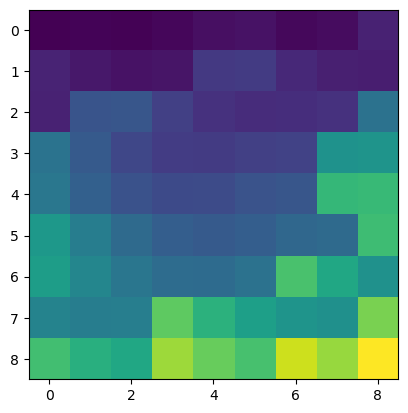

In [11]:
# Plotting the function
import matplotlib.pyplot as plt
shape = (9, 9)
plt.imshow(uD.x.array.reshape(shape))

Next, we identify the boundary facets. (Note, facet means topological entity that is D-1 dimenion, where D is the dimension of the domain. For example, for the 2D domain in this tutorial, facet means lines.)

In [9]:
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)

Can we see the indices of all the facets?

In [ ]:
domain.topology.index_map(2).size_global # 2 is the dimension of the topology entity

64

After running `domain.topology.create_connectivity(fdim, tdim)`, the `dim=1` entities are also defined.

In [110]:
domain.topology.index_map(1).size_global 

144

There are in total 144 edges, among which 32 are on the outer boundary. The indices are found below. 

In [9]:
boundary_facets

array([  0,   1,   3,   5,   9,  13,  17,  23,  27,  35,  39,  49,  53,
        65,  69,  83,  86,  87, 100, 101, 102, 113, 114, 123, 124, 131,
       132, 137, 138, 141, 142, 143], dtype=int32)

The coordinates of vertices can be accessed in `geometry`.

In [15]:
domain.geometry.x

array([[0.   , 0.   , 0.   ],
       [0.   , 0.125, 0.   ],
       [0.125, 0.   , 0.   ],
       [0.125, 0.125, 0.   ],
       [0.   , 0.25 , 0.   ],
       [0.125, 0.25 , 0.   ],
       [0.25 , 0.   , 0.   ],
       [0.25 , 0.125, 0.   ],
       [0.   , 0.375, 0.   ],
       [0.125, 0.375, 0.   ],
       [0.25 , 0.25 , 0.   ],
       [0.375, 0.   , 0.   ],
       [0.375, 0.125, 0.   ],
       [0.   , 0.5  , 0.   ],
       [0.125, 0.5  , 0.   ],
       [0.25 , 0.375, 0.   ],
       [0.375, 0.25 , 0.   ],
       [0.5  , 0.   , 0.   ],
       [0.5  , 0.125, 0.   ],
       [0.   , 0.625, 0.   ],
       [0.125, 0.625, 0.   ],
       [0.25 , 0.5  , 0.   ],
       [0.375, 0.375, 0.   ],
       [0.5  , 0.25 , 0.   ],
       [0.625, 0.   , 0.   ],
       [0.625, 0.125, 0.   ],
       [0.   , 0.75 , 0.   ],
       [0.125, 0.75 , 0.   ],
       [0.25 , 0.625, 0.   ],
       [0.375, 0.5  , 0.   ],
       [0.5  , 0.375, 0.   ],
       [0.625, 0.25 , 0.   ],
       [0.75 , 0.   , 0.   ],
       [0.

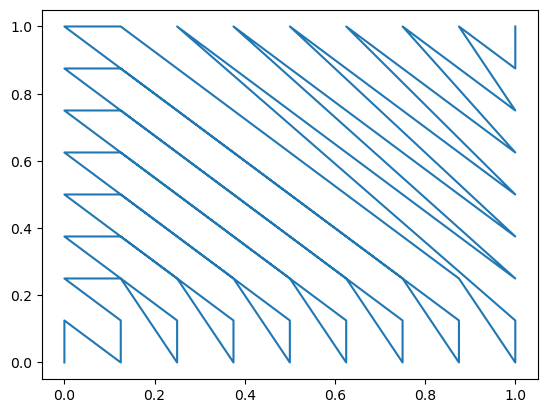

In [25]:
plt.plot(domain.geometry.x[:,0], domain.geometry.x[:,1], markersize=2)

Next, we need to locate the local degree of freedom on each facet. 

In [17]:
boundary_dofs = fem.locate_dofs_topological(V, fdim, boundary_facets)
bc = fem.dirichletbc(uD, boundary_dofs)

In [18]:
boundary_dofs

array([ 0,  1,  2,  4,  6,  8, 11, 13, 17, 19, 24, 26, 32, 34, 41, 43, 44,
       51, 52, 53, 59, 60, 65, 66, 70, 71, 74, 75, 77, 78, 79, 80],
      dtype=int32)

In [26]:
dof = V.tabulate_dof_coordinates()

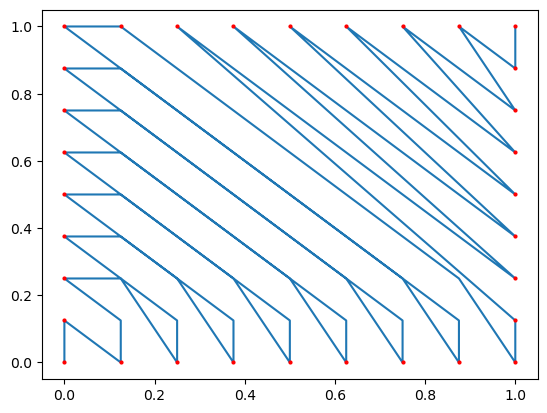

In [29]:
plt.plot(dof[:,0], dof[:,1], markersize=2)
plt.plot(dof[boundary_dofs, 0], dof[boundary_dofs, 1], 'ro', markersize=2)

The geometry is correctly defined. Now, let's define the trial and test functions.

In [30]:
import ufl
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

And define the source term.

In [31]:
from dolfinx import default_scalar_type
f = fem.Constant(domain, default_scalar_type(-6))

Define the variational problem.

In [32]:
a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx

Note that the intergration is already defined in the `ufl.dx`, so it's omitted in the Python code. Other than this, the Python code looks very similar to the mathematical variational problem. 

We now form and solve the linear system.

In [33]:
from dolfinx.fem.petsc import LinearProblem
problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

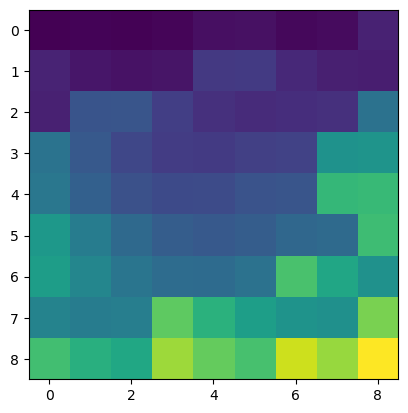

In [38]:
plt.imshow(uh.x.array.reshape(shape))

We can export the results to visualize in paraview.

In [89]:
from dolfinx import io
from pathlib import Path
results_folder = Path("results")
results_folder.mkdir(exist_ok=True, parents=True)
filename = results_folder / "fundamentals"
with io.VTXWriter(domain.comm, filename.with_suffix(".bp"), [uh]) as vtx:
    vtx.write(0.0)
with io.XDMFFile(domain.comm, filename.with_suffix(".xdmf"), "w") as xdmf:
    xdmf.write_mesh(domain)
    xdmf.write_function(uh)

## 2 Weak imposition of Dirichlet conditions for the Poisson problem

In [111]:
import numpy as np
N = 8
points = np.array([[0, 0], [1, 1]])
domain = mesh.create_rectangle(MPI.COMM_WORLD, points,[N, N], mesh.CellType.quadrilateral)
V = fem.functionspace(domain, ("Lagrange", 1))

In [113]:
uD = fem.Function(V)
x = ufl.SpatialCoordinate(domain) # x here is an abstract representation of the coordinates, without specific values defined
u_ex = 1 + x[0]**2 + 2*x[1]**2
uD.interpolate(fem.Expression(u_ex, V.element.interpolation_points()))
f = -ufl.div(ufl.grad(u_ex))

In [114]:
V.element.interpolation_points()

array([[0., 0.],
       [1., 0.],
       [0., 1.],
       [1., 1.]])

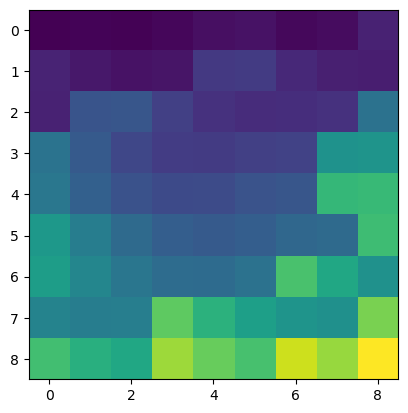

In [115]:
plt.imshow(uD.x.array.reshape(9, 9))

We start again from the integration by parts

$$
\int_\Omega \nabla u\cdot \nabla v \,\mathrm{d}x - \int_{\partial\Omega} \nabla u\cdot nv \,\mathrm{d}s = \int_\Omega fv \,\mathrm{d}x
$$

We add two terms to the formulation

$$
-\int_{\partial\Omega} \nabla v\cdot n(u-u_D) \,\mathrm{d}s + \frac{\alpha}{h} \int_{\partial\Omega} (u-u_D)v\,\mathrm{d}s
$$

When boundary condition is met, these two terms vanish, so adding these two terms would not make the solution inexact. The first term makes the bilinear form symmetric, which is generally desirable in finite element methods. The second term penaltizes the deviation of $u$ from $u_D$ at boundaries, enforcing the boundary conditions to be met.

With these two terms, we can write the bilinear and linear forms of the variational formulation:

$$
a(u, v) = \int_\Omega \nabla u\cdot \nabla v \,\mathrm{d}x - \int_{\partial\Omega} \nabla u\cdot nv \,\mathrm{d}s -\int_{\partial\Omega} \nabla v\cdot nu \,\mathrm{d}s + \frac{\alpha}{h} \int_{\partial\Omega} uv\,\mathrm{d}s
$$

$$
L(v) = \int_\Omega fv \,\mathrm{d}x -\int_{\partial\Omega} \nabla v\cdot nu_D \,\mathrm{d}s + \frac{\alpha}{h} \int_{\partial\Omega} u_Dv\,\mathrm{d}s
$$

Now put this formulation in Python code.

In [116]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
n = ufl.FacetNormal(domain)
h = 2 * ufl.CellDiameter(domain)
alpha = fem.Constant(domain, default_scalar_type(10))

In [122]:
from ufl import inner, grad, dx, ds, dot
a = inner(grad(u), grad(v)) * dx - inner(n, grad(u)) * v * ds - inner(n, grad(v)) * u * ds + alpha / h * u * v * ds
L = f * v * dx - inner(n, grad(v)) * uD * ds + alpha / h * uD * v * ds

In [123]:
problem = LinearProblem(a, L)
uh = problem.solve()

In [119]:
uh

Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, quadrilateral, 1, gll_warped, unset, False, float64, []), (2,)), 8), Basix element (P, quadrilateral, 1, gll_warped, unset, False, float64, [])), 15)

In [124]:
from dolfinx import io
from pathlib import Path
results_folder = Path("results")
results_folder.mkdir(exist_ok=True, parents=True)
filename = results_folder / "fundamentals"
with io.VTXWriter(domain.comm, filename.with_suffix(".bp"), [uh]) as vtx:
    vtx.write(0.0)
with io.XDMFFile(domain.comm, filename.with_suffix(".xdmf"), "w") as xdmf:
    xdmf.write_mesh(domain)
    xdmf.write_function(uh)

## 3 Deflection of a membrane

Consider an elastic membrane under pressure load $p$:

$$
-T\nabla^2 D = p \;\;\mathrm{in} \;\; \Omega = \{ (x, y) | x^2+y^2\le R^2\}
$$

where

$$
p (x, y) = \frac{A}{2\pi\sigma} e^{-\frac{|\mathbf{x}-\mathbf{x_0}|^2}{2\sigma^2}}
$$

With some non-dimensionalization, we can rewrite the problem as

$$
-\nabla^2 w = 4 e^{-\beta^2(x^2 + (y-1)^2)}
$$

boundary condition is

$$
w = 0 \;\; \mathrm{in} \;\; \partial\Omega=\{ (x, y) | x^2+y^2= 1\}
$$

In [1]:
import gmsh
gmsh.initialize()

In [2]:
membrane = gmsh.model.occ.addDisk(0,0,0,1,1)
gmsh.model.occ.synchronize()

In [3]:
gdim = 2
gmsh.model.addPhysicalGroup(gdim, [membrane], 1)

1

In [4]:
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 0.05)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 0.05)
gmsh.model.mesh.generate(gdim)

Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 0.000178399s, CPU 0.000177s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0678164s, CPU 0.064954s)
Info    : 1550 nodes 3099 elements


In [5]:
from dolfinx.io import gmshio
from mpi4py import MPI

gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD
domain, cell_markers, facet_markers = gmshio.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=gdim)

(np.float64(-1.1),
 np.float64(1.1),
 np.float64(-1.099658100200898),
 np.float64(1.099658100200898))

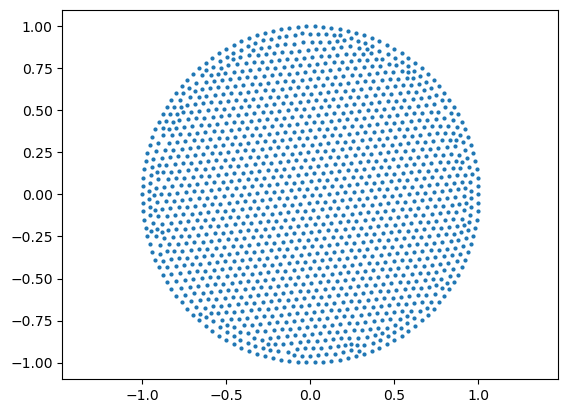

In [6]:
# show vertices in domain
x = domain.geometry.x
import matplotlib.pyplot as plt
plt.plot(x[:,0], x[:,1], "o", markersize=2)
plt.axis("equal")

Is the topology already defined?

In [7]:
domain.topology.index_map(2).size_global # 2 is the dimension of the topology entity

2972

The index_map for dim=1 is not yet defined, suggesting that only faces are generated, but edges are not labeled yet. However, for a certain face plan, the edges are already determined, so it's just a matter of creating the connectivity.

In [8]:
domain.topology.create_connectivity(2, 1)

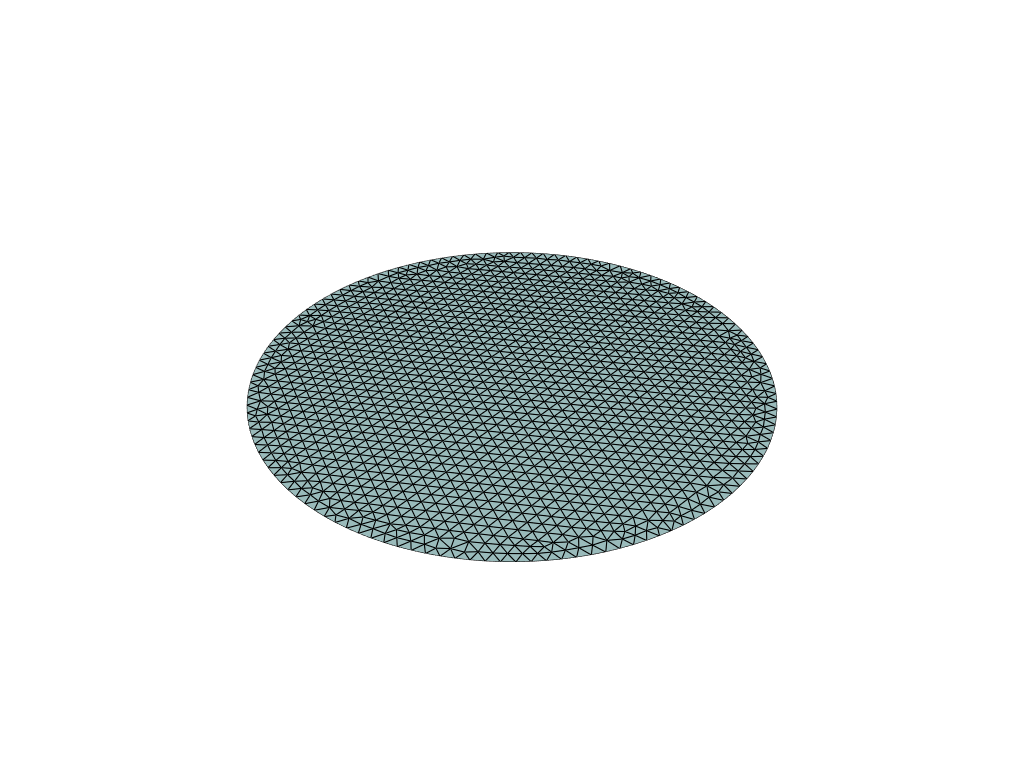

In [10]:
# display the mesh using pyvista
import pyvista
pyvista.set_jupyter_backend("static")
from dolfinx import plot
# we need to convert dolfinx mesh representation to pyvista before plotting
vtk_mesh = plot.vtk_mesh(domain)
grid = pyvista.UnstructuredGrid(*vtk_mesh) 
################################################# 
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.show()

In [11]:
grid.point_data.keys()

[]

In [53]:
from dolfinx import fem
V = fem.functionspace(domain, ("Lagrange", 5))

Define a spatially varying load

In [54]:
import ufl
from dolfinx import default_scalar_type

x = ufl.SpatialCoordinate(domain) # x here is an abstract representation of the coordinates, without specific values defined
beta = fem.Constant(domain, default_scalar_type(12))
R0 = fem.Constant(domain, default_scalar_type(0.3))
p = 4 * ufl.exp(-beta**2 * (x[0]**2 + (x[1] - R0)**2))

Define trial and test functions

In [55]:
from ufl import inner, grad, dx

w = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
a = inner(grad(w), grad(v)) * dx
L = p * v * dx

Define boundary condition.

In [56]:
import numpy as np


def on_boundary(x):
    return np.isclose(np.sqrt(x[0]**2 + x[1]**2), 1)


boundary_dofs = fem.locate_dofs_geometrical(V, on_boundary)

In [57]:
boundary_dofs

array([    0,     2,    21,    23,    42,   141,   171,   256,   272,
         401,   446,   576,   731,   791,   946,  1151,  1226,  1416,
        1656,  1746,  2191,  2306,  2766,  2792,  2916,  3431,  3581,
        4126,  4301,  4856,  5041,  5626,  5662,  5682,  5702,  5722,
        5906,  6226,  6676,  6692,  6891,  7216,  7701,  7911,  8256,
        8776,  9001,  9341,  9876, 10116, 10966, 11231, 12071, 12366,
       13201, 13511, 14331, 14671, 15491, 15841, 16641, 17011, 17796,
       18176, 18951, 19331, 20106, 20486, 21261, 21641, 22416, 22796,
       23566, 23946, 24706, 25086, 25576, 25836, 26231, 26911, 27281,
       27966, 28336, 29006, 29371, 29811, 29826, 30036, 30806, 30831,
       30846, 30861, 30886, 31021, 31416, 31741, 31886, 32211, 32636,
       32961, 33361, 33656, 34021, 34301, 34661, 34921, 35246, 35481,
       35696, 35781, 35996, 36241, 36426, 36581, 36636, 36796, 36946,
       37056, 37071, 37186, 37236, 37301, 37316, 37371, 37406, 37431],
      dtype=int32)

In [58]:
from dolfinx import mesh
domain.topology.create_connectivity(1, 2)
boundary_facets = mesh.exterior_facet_indices(domain.topology)

In [59]:
boundary_facets

array([   1,    3,    9,   12,   13,   20,   37,   43,   59,   65,   79,
         88,  112,  128,  140,  167,  188,  203,  233,  256,  274,  325,
        346,  400,  407,  431,  486,  516,  574,  606,  669,  702,  764,
        770,  776,  782,  788,  824,  864,  907,  913,  952,  990, 1041,
       1083, 1120, 1174, 1219, 1253, 1311, 1359, 1447, 1498, 1580, 1637,
       1717, 1777, 1854, 1919, 1995, 2061, 2131, 2202, 2270, 2341, 2409,
       2480, 2548, 2619, 2687, 2758, 2826, 2897, 2961, 3032, 3097, 3167,
       3182, 3229, 3303, 3356, 3428, 3483, 3554, 3606, 3673, 3683, 3685,
       3725, 3800, 3801, 3802, 3803, 3804, 3831, 3897, 3898, 3924, 3985,
       4010, 4070, 4093, 4148, 4168, 4220, 4241, 4287, 4306, 4349, 4350,
       4363, 4399, 4412, 4443, 4444, 4452, 4480, 4485, 4501, 4502, 4507,
       4511, 4517, 4518, 4519, 4520], dtype=int32)

In [60]:
boundary_dofs = fem.locate_dofs_topological(V, 1, boundary_facets)

In [61]:
boundary_dofs

array([    0,     2,     7,     8,     9,    10,    21,    23,    28,
          29,    30,    31,    42,    48,    49,    50,    51,    67,
          68,    69,    70,   141,   146,   147,   148,   149,   171,
         172,   173,   174,   175,   256,   261,   262,   263,   264,
         272,   277,   278,   279,   280,   401,   406,   407,   408,
         409,   446,   447,   448,   449,   450,   576,   581,   582,
         583,   584,   731,   736,   737,   738,   739,   791,   792,
         793,   794,   795,   946,   951,   952,   953,   954,  1151,
        1156,  1157,  1158,  1159,  1226,  1227,  1228,  1229,  1230,
        1416,  1421,  1422,  1423,  1424,  1656,  1661,  1662,  1663,
        1664,  1746,  1747,  1748,  1749,  1750,  2191,  2196,  2197,
        2198,  2199,  2306,  2307,  2308,  2309,  2310,  2766,  2771,
        2772,  2773,  2774,  2792,  2797,  2798,  2799,  2800,  2916,
        2917,  2918,  2919,  2920,  3431,  3436,  3437,  3438,  3439,
        3581,  3582,

In [62]:
bc = fem.dirichletbc(default_scalar_type(0), boundary_dofs, V)

In [63]:
from dolfinx.fem.petsc import LinearProblem

problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

In [64]:
uh

Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, equispaced, unset, False, float64, []), (2,)), 0), Basix element (P, triangle, 5, gll_warped, unset, False, float64, [])), 4)

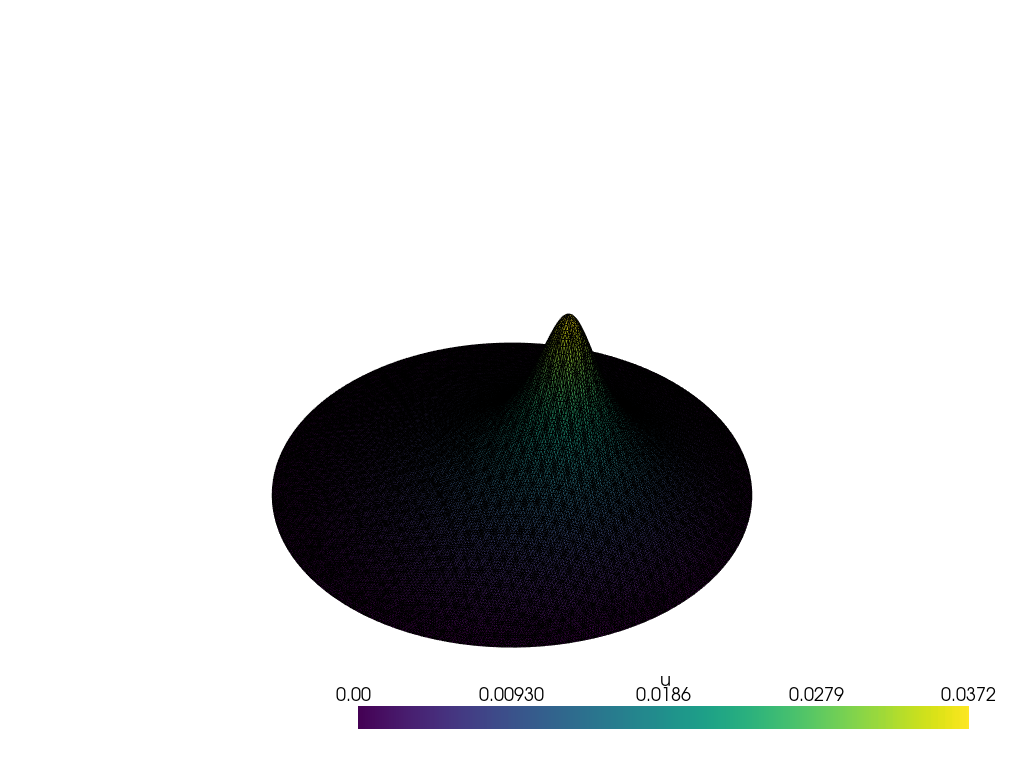

In [67]:
# display the mesh using pyvista
import pyvista
pyvista.set_jupyter_backend("static")
from dolfinx import plot
# we need to convert dolfinx mesh representation to pyvista before plotting
# vtk_mesh = plot.vtk_mesh(domain)
grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(V)) 
grid.point_data["u"] = uh.x.array
warped = grid.warp_by_scalar("u", factor=25)
################################################# 
plotter = pyvista.Plotter()
plotter.add_mesh(warped, show_edges=True)
plotter.show()

We also want to plot the pressure field, which requires interpolating the ufl expression with the grid points.

In [68]:
Q = fem.functionspace(domain, ("Lagrange", 5))
expr = fem.Expression(p, Q.element.interpolation_points())
pressure = fem.Function(Q)
pressure.interpolate(expr)

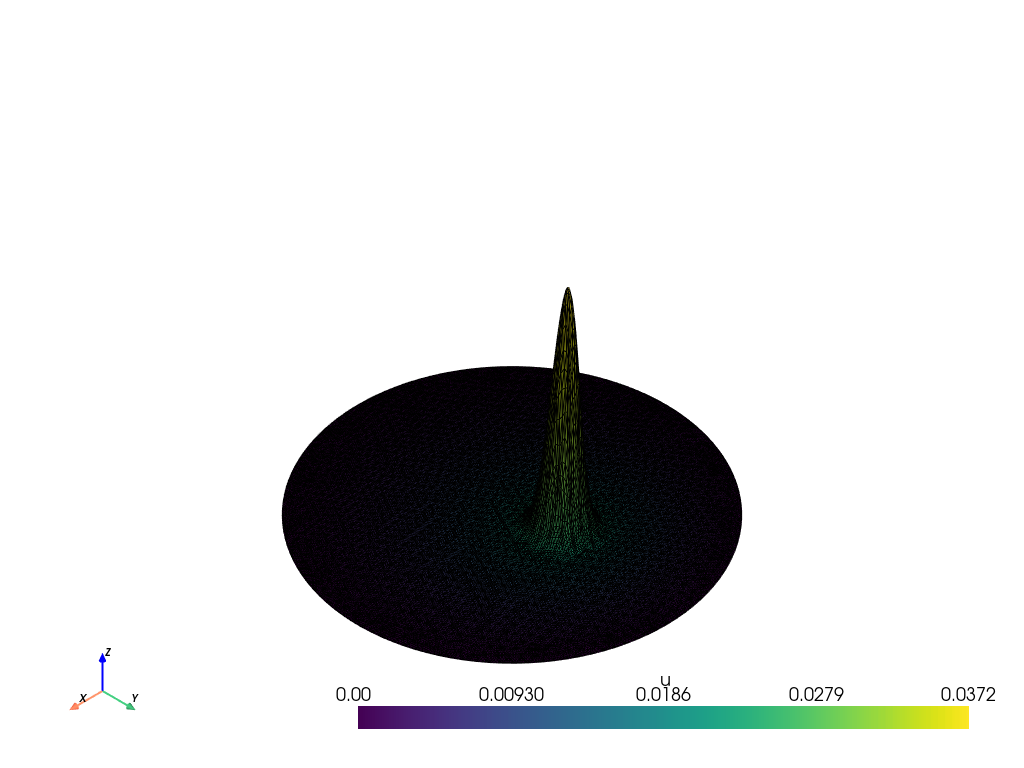

In [69]:
grid.point_data["p"] = pressure.x.array
warped = grid.warp_by_scalar("p", factor=.3)
warped.plot(show_edges=True)

## 4 Mixed formulation for the Poisson equation

$$
\sigma - \nabla u = 0
$$

$$
\nabla\cdot\sigma = -f
$$

with BCs

$$
u = u_0 
$$

$$
\sigma\cdot n = g
$$

In [1]:
from petsc4py import PETSc
import dolfinx
from mpi4py import MPI
import numpy as np

from basix.ufl import element, mixed_element
from dolfinx import default_real_type, fem, io, mesh
from dolfinx.fem.petsc import LinearProblem
from ufl import Measure, SpatialCoordinate, TestFunctions, TrialFunctions, div, exp, inner

msh = mesh.create_unit_square(MPI.COMM_WORLD, 32, 32, mesh.CellType.quadrilateral)

k = 1
Q_el = element("BDMCF", msh.basix_cell(), k, dtype=default_real_type)
P_el = element("DG", msh.basix_cell(), k - 1, dtype=default_real_type)
V_el = mixed_element([Q_el, P_el])
V = fem.functionspace(msh, V_el)

(sigma, u) = TrialFunctions(V)
(tau, v) = TestFunctions(V)

x = SpatialCoordinate(msh)
f = 10.0 * exp(-((x[0] - 0.5) * (x[0] - 0.5) + (x[1] - 0.5) * (x[1] - 0.5)) / 0.02)

dx = Measure("dx", msh)
a = inner(sigma, tau) * dx + inner(u, div(tau)) * dx + inner(div(sigma), v) * dx
L = -inner(f, v) * dx

# Get subspace of V
V0 = V.sub(0)

fdim = msh.topology.dim - 1
facets_top = mesh.locate_entities_boundary(msh, fdim, lambda x: np.isclose(x[1], 1.0))
Q, _ = V0.collapse()
dofs_top = fem.locate_dofs_topological((V0, Q), fdim, facets_top)


def f1(x):
    values = np.zeros((2, x.shape[1]))
    values[1, :] = np.sin(5 * x[0])
    return values


f_h1 = fem.Function(Q)
f_h1.interpolate(f1)
bc_top = fem.dirichletbc(f_h1, dofs_top, V0)


facets_bottom = mesh.locate_entities_boundary(msh, fdim, lambda x: np.isclose(x[1], 0.0))
dofs_bottom = fem.locate_dofs_topological((V0, Q), fdim, facets_bottom)


def f2(x):
    values = np.zeros((2, x.shape[1]))
    values[1, :] = -np.sin(5 * x[0])
    return values


f_h2 = fem.Function(Q)
f_h2.interpolate(f2)
bc_bottom = fem.dirichletbc(f_h2, dofs_bottom, V0)


bcs = [bc_top, bc_bottom]

problem = LinearProblem(
    a,
    L,
    bcs=bcs,
    petsc_options={
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "superlu_dist",
    },
)
try:
    w_h = problem.solve()
except PETSc.Error as e:  # type: ignore
    if e.ierr == 92:
        print("The required PETSc solver/preconditioner is not available. Exiting.")
        print(e)
        exit(0)
    else:
        raise e

sigma_h, u_h = w_h.split()

with io.XDMFFile(msh.comm, "out_mixed_poisson/u.xdmf", "w") as file:
    file.write_mesh(msh)
    file.write_function(u_h)